In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
# 实现注意力的可视化
# 输入matrices的形状是（要显示的行数，要显示的列数，查询的数目，键的数目）
# 每个矩阵（查询数目 × 键数目）对应一个子图。

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图"""
    # 使用 Matplotlib 的 rcParams 来设置 SVG 格式
    plt.rcParams['figure.dpi'] = 120  # 调整分辨率
    plt.rcParams['savefig.format'] = 'svg'  # 设置保存格式为 SVG

    # 获取矩阵的行列数
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]

    # 绘图相关参数讲解
    # num_rows, num_cols 子图网格的行列数
    # figsize 整个图像的宽度和高度
    # sharex=True, sharey=True 所有子图共享相同的x轴刻度
    # squeeze=False 无论子图网格的形状如何，axes 始终是一个二维数组。
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    # axes 的形状：(num_rows, num_cols)

    # 遍历每一行的子图和对应的矩阵
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        # 遍历每一列的子图和对应的矩阵
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

    # 添加颜色条
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    plt.show()

In [25]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)

In [8]:
import matplotlib.pyplot as plt

def plot_kernel_reg(test_inputs, true_values, predicted_values, train_inputs, train_targets):
    """
    绘制训练样本、真实函数和预测函数。

    参数:
    - test_inputs: 测试输入数据
    - true_values: 测试数据对应的真实值/函数值
    - predicted_values: 测试数据对应的预测值
    - train_inputs: 训练输入数据
    - train_targets: 训练输出目标值
    """
    plt.figure(figsize=(8, 6))

    # 绘制真实函数和预测函数
    plt.plot(test_inputs, true_values, label='Ground Truth', color='blue', linestyle='-', linewidth=2)
    plt.plot(test_inputs, predicted_values, label='Predictions', color='orange', linestyle='--', linewidth=2)

    # 绘制训练数据点
    plt.scatter(train_inputs, train_targets, label='Training Data', color='red', alpha=0.5, marker='o')

    # 设置图例、标题和坐标轴标签
    plt.legend(loc='upper right', fontsize=12)
    plt.title('Kernel Regression Visualization', fontsize=14)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)

    # 设置坐标轴范围
    plt.xlim(0, 5)
    plt.ylim(-1, 5)

    # 显示绘图
    plt.grid(alpha=0.3)
    plt.show()

## 平均汇聚

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$

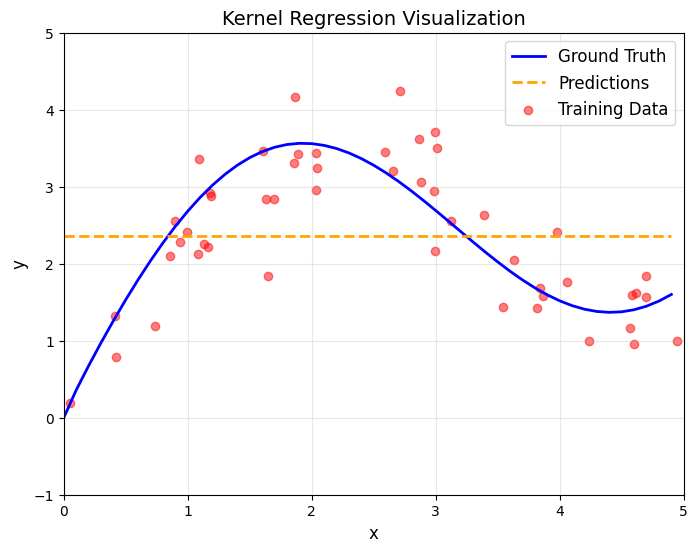

In [9]:
# 将 y_train.mean() 的值重复多次，形成一个与测试样本数量 n_test 相同的张量。
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
# 调用绘图函数
plot_kernel_reg(
    test_inputs=x_test,
    true_values=y_truth,
    predicted_values=y_hat,
    train_inputs=x_train,
    train_targets=y_train
)

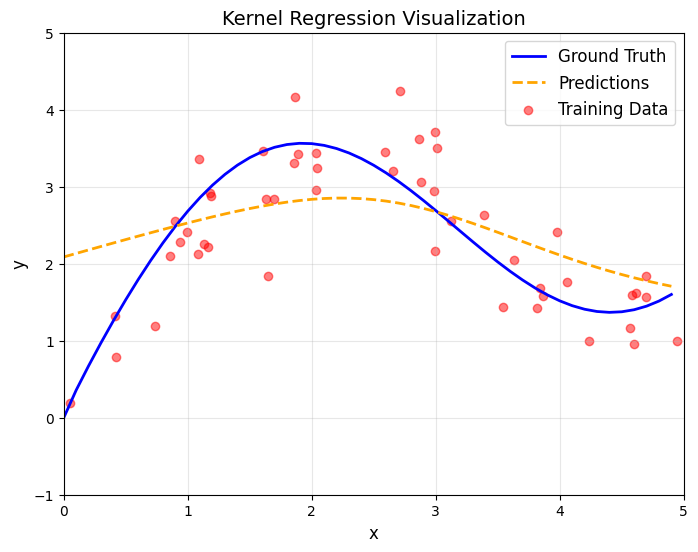

In [10]:
# 不带参数的注意力汇聚

# x_test: 测试输入张量，形状为 (n_test,)
# n_train: 训练样本的数量      n_test==n_train
# repeat_interleave(n_train)：对 x_test 中的每个元素重复 n_train 次，形成长度为 n_test * n_train 的一维张量。
# .reshape((-1, n_train))：将其重塑为形状 (n_test, n_train) 的二维张量。
# X_repeat的形状:(n_test,n_train),
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))

# x_train 的形状是 (n_train,)
# 广播机制 x_train 的形状扩展为 (n_test, n_train)
# (X_repeat - x_train)**2：计算每个测试样本与每个训练样本之间的平方距离。
# - (...) / 2：将距离值取负并除以 2，模拟高斯核函数的形式。
# nn.functional.softmax(..., dim=1)：对每行应用 Softmax 函数，将距离转化为概率分布（注意力权重），和为 1。
# attention_weights 的形状为 (n_test, n_train)
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)

# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
# y_train 的形状是 (n_train,)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(
    test_inputs=x_test,
    true_values=y_truth,
    predicted_values=y_hat,
    train_inputs=x_train,
    train_targets=y_train
)

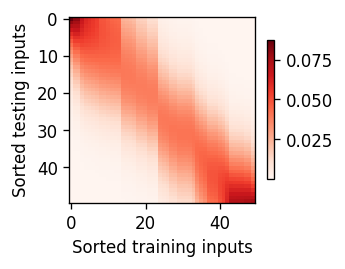

In [11]:
# 测试数据的输入相当于查询 训练数据的输入相当于键
# 查询和键的距离越接近 对应的注意力权重就越高

show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [12]:
# 批量矩阵乘法示例
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [13]:
# 使用小批量矩阵乘法来计算小批量数据中的加权平均值
# weights形状：(2, 10)，表示有2个批次（batch），每个批次有10个权重。
weights = torch.ones((2, 10)) * 0.1
# values：(2, 10)，表示有2个批次（batch），每个批次有10个值。
values = torch.arange(20.0).reshape((2, 10))
# unsqueeze(1) 在1维后面增加一个维度 weights(2, 10)->(2,1,10)
# unsqueeze(-1) 在最后一维增加一个维度 values(2, 10)->(2,10,1)。
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))
# 最后结果(2,1,1)

tensor([[[ 4.5000]],

        [[14.5000]]])

In [16]:
# 使用小批量矩阵乘法 基于带参数的注意力汇聚 定义核回归带参数模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # w是一个形状为(1,)的参数 用于调整核函数的带宽或缩放因子
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    # queries查询点 就是x_train (n_train),
    # keys (n_train, n_train-1) 每行包含除自身外的所有训练输入
    # values (n_train, n_train-1) 每行包含除自身外的所有训练输出
    def forward(self, queries, keys, values):
        # queries (n_train)->(n_train*(n_train-1))->(n_train, n_train-1)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # 使用批量矩阵乘法进行计算
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [17]:
# 将训练集变换为键和值用于训练模型
# 任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算

# x_train = (n_train)
# X_tile = (n_train, n_train)
X_tile = x_train.repeat((n_train, 1))
# y_train = (n_train)
# y_tile = (n_train, n_train)
Y_tile = y_train.repeat((n_train, 1))
# torch.eye(n_train)是形状为(n_train, n_train)对角线为1的单位阵
# 1 - torch.eye(n_train) 对角线为0，其他位置为1的掩码
# .type(torch.bool) 转换成bool掩码
# X_tile[(1 - torch.eye(n_train)).type(torch.bool)] 一维向量，包含所有非对角线元素
# keys形状 (n_train, n_train-1) 每行包含除自身外的所有训练输入
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# 同上 values形状 (n_train, n_train-1) 每行包含除自身外的所有训练输出
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

[**训练带参数的注意力汇聚模型**]时，使用平方损失函数和随机梯度下降。


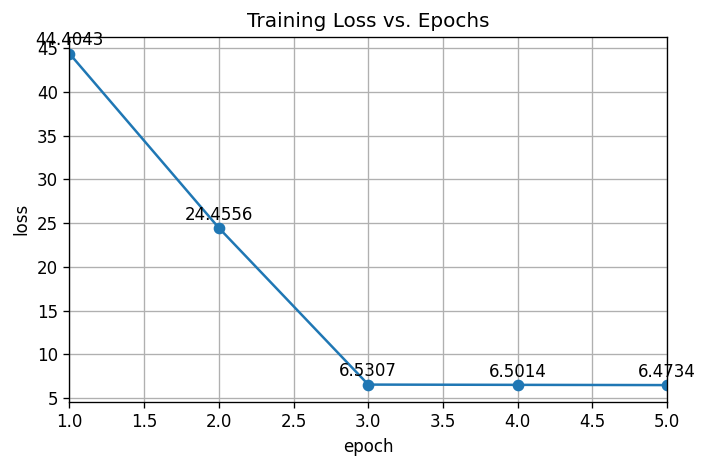

In [23]:
# 使用平方随时和随机梯度下降
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)

plt.figure(figsize=(6, 4))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(1, 5)
epochs = []
losses = []

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()

    # 记录损失值
    current_loss = float(l.sum())
    epochs.append(epoch + 1)
    losses.append(current_loss)

# 训练结束后绘制损失曲线
plt.plot(epochs, losses, 'o-', linewidth=1.5)
plt.grid(True)
plt.title('Training Loss vs. Epochs')

# 添加数据标签
for i, (x, y) in enumerate(zip(epochs, losses)):
    plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points",
                 xytext=(0, 5), ha='center')

plt.tight_layout()
plt.show()

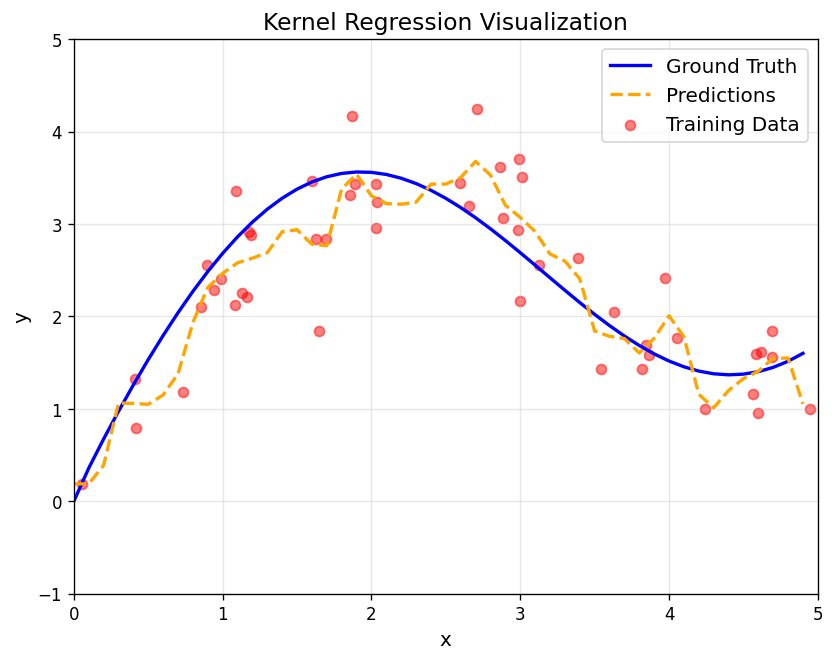

In [24]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(
    test_inputs=x_test,
    true_values=y_truth,
    predicted_values=y_hat,
    train_inputs=x_train,
    train_targets=y_train
)

为什么新的模型更不平滑了呢？
下面看一下输出结果的绘制图：
与非参数的注意力汇聚模型相比，
带参数的模型加入可学习的参数后，
[**曲线在注意力权重较大的区域变得更不平滑**]。


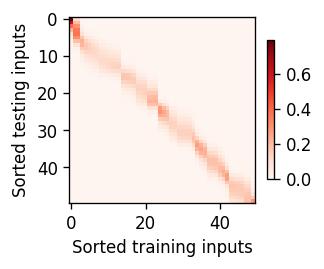

In [22]:
# 曲线在注意力权重较大的区域变得不平滑
# 导致新的模型更不平滑了
show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# Nadaraya-Watson核回归模型完整计算过程（具体参数值演示）

### 数据生成阶段

假设我们使用5个训练样本（而非原代码中的50个）。

```python
def f(x):
    return 2 * torch.sin(x) + x**0.8

# 假设生成的x_train和对应的y_train如下
x_train = torch.tensor([0.2, 0.8, 2.1, 3.4, 4.5])  # 形状:[5]
# 计算无噪声的y值
y_clean = 2 * torch.sin(x_train) + x_train**0.8
# y_clean = tensor([1.15, 1.73, 1.87, 0.22, 1.63])

# 假设添加噪声后的训练标签
y_train = tensor([1.05, 1.83, 1.67, 0.32, 1.73])  # 形状:[5]

# 训练样本数
n_train = 5
```

---

### 训练数据准备（"留一法"）

```python
# 步骤1: 创建重复的训练输入矩阵
X_tile = x_train.repeat((n_train, 1))
# X_tile形状:[5,5]
# X_tile =
# [[0.2, 0.8, 2.1, 3.4, 4.5],
#  [0.2, 0.8, 2.1, 3.4, 4.5],
#  [0.2, 0.8, 2.1, 3.4, 4.5],
#  [0.2, 0.8, 2.1, 3.4, 4.5],
#  [0.2, 0.8, 2.1, 3.4, 4.5]]

# 步骤2: 创建重复的训练输出矩阵
Y_tile = y_train.repeat((n_train, 1))
# Y_tile形状:[5,5]
# Y_tile =
# [[1.05, 1.83, 1.67, 0.32, 1.73],
#  [1.05, 1.83, 1.67, 0.32, 1.73],
#  [1.05, 1.83, 1.67, 0.32, 1.73],
#  [1.05, 1.83, 1.67, 0.32, 1.73],
#  [1.05, 1.83, 1.67, 0.32, 1.73]]

# 步骤3: 创建布尔掩码
mask = (1 - torch.eye(n_train)).type(torch.bool)
# mask =
# [[False,  True,  True,  True,  True],
#  [ True, False,  True,  True,  True],
#  [ True,  True, False,  True,  True],
#  [ True,  True,  True, False,  True],
#  [ True,  True,  True,  True, False]]

# 步骤4: 使用掩码提取键值
keys = X_tile[mask].reshape((n_train, -1))
# keys形状:[5,4]
# keys =
# [[0.8, 2.1, 3.4, 4.5],  # 排除x=0.2
#  [0.2, 2.1, 3.4, 4.5],  # 排除x=0.8
#  [0.2, 0.8, 3.4, 4.5],  # 排除x=2.1
#  [0.2, 0.8, 2.1, 4.5],  # 排除x=3.4
#  [0.2, 0.8, 2.1, 3.4]]  # 排除x=4.5

values = Y_tile[mask].reshape((n_train, -1))
# values形状:[5,4]
# values =
# [[1.83, 1.67, 0.32, 1.73],  # 排除y=1.05
#  [1.05, 1.67, 0.32, 1.73],  # 排除y=1.83
#  [1.05, 1.83, 0.32, 1.73],  # 排除y=1.67
#  [1.05, 1.83, 1.67, 1.73],  # 排除y=0.32
#  [1.05, 1.83, 1.67, 0.32]]  # 排除y=1.73
```

---

### 模型初始化和前向传播

```python
# 初始化模型，假设随机生成的w参数值为1.5
net = NWKernelRegression()
net.w = nn.Parameter(torch.tensor([1.5]))

# 前向传播过程
# 步骤1: 重塑查询点
queries = x_train.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
# queries形状:[5,4]
# queries =
# [[0.2, 0.2, 0.2, 0.2],
#  [0.8, 0.8, 0.8, 0.8],
#  [2.1, 2.1, 2.1, 2.1],
#  [3.4, 3.4, 3.4, 3.4],
#  [4.5, 4.5, 4.5, 4.5]]

# 步骤2: 计算查询点与键之间的差值
diff = queries - keys
# diff形状:[5,4]
# diff =
# [[-0.6, -1.9, -3.2, -4.3],  # 0.2与其他点的差
#  [ 0.6, -1.3, -2.6, -3.7],  # 0.8与其他点的差
#  [ 1.9,  1.3, -1.3, -2.4],  # 2.1与其他点的差
#  [ 3.2,  2.6,  1.3, -1.1],  # 3.4与其他点的差
#  [ 4.3,  3.7,  2.4,  1.1]]  # 4.5与其他点的差

# 步骤3: 应用w参数和高斯核函数
# diff * w
scaled_diff = diff * net.w  # w = 1.5
# scaled_diff =
# [[-0.9, -2.85, -4.8, -6.45],
#  [ 0.9, -1.95, -3.9, -5.55],
#  [ 2.85, 1.95, -1.95, -3.6],
#  [ 4.8,  3.9,  1.95, -1.65],
#  [ 6.45, 5.55,  3.6,  1.65]]

# -((diff * w)**2 / 2)
exponent = -((scaled_diff)**2 / 2)
# exponent =
# [[-0.405, -4.06, -11.52, -20.79],
#  [ 0.405, -1.901, -7.605, -15.4],
#  [ 4.06,  1.901, -1.901, -6.48],
#  [11.52,  7.605,  1.901, -1.361],
#  [20.79, 15.4,   6.48,   1.361]]

# 步骤4: 应用softmax函数计算注意力权重
attention_weights = nn.functional.softmax(exponent, dim=1)
# attention_weights形状:[5,4]
# attention_weights ≈
# [[0.644, 0.307, 0.046, 0.003],  # 对x=0.2的注意力分布
#  [0.581, 0.385, 0.033, 0.001],  # 对x=0.8的注意力分布
#  [0.192, 0.584, 0.192, 0.032],  # 对x=2.1的注意力分布
#  [0.003, 0.046, 0.307, 0.644],  # 对x=3.4的注意力分布
#  [0.001, 0.033, 0.385, 0.581]]  # 对x=4.5的注意力分布
```

---

### 计算加权平均（最终预测）

```python
# 步骤1: 准备进行批量矩阵乘法
weights_3d = attention_weights.unsqueeze(1)  # 形状:[5,1,4]
values_3d = values.unsqueeze(-1)  # 形状:[5,4,1]

# 步骤2: 执行批量矩阵乘法
output = torch.bmm(weights_3d, values_3d)  # 形状:[5,1,1]

# 步骤3: 重塑为一维向量
y_pred = output.reshape(-1)  # 形状:[5]
# y_pred ≈ [1.66, 1.59, 1.53, 1.48, 1.45]
```



# `torch.repeat_interleave` 函数用法

`torch.repeat_interleave` 是 PyTorch 中用于重复张量元素的函数。它允许你沿特定维度对张量的元素进行重复，从而扩展张量的形状。

---

## 函数签名

```python
torch.repeat_interleave(input, repeats, dim=None)
```

---

## 参数解释

1. **`input`**:
   - 需要重复的输入张量。

2. **`repeats`**:
   - 指定重复次数：
     - 如果是一个整数，表示所有元素重复相同的次数。
     - 如果是一个张量（形状为 `[input.size(dim)]`），表示每个元素重复的次数。

3. **`dim`**:
   - 指定沿哪个维度重复：
     - 如果为 `None`，会将输入张量展平（flatten），然后对所有元素进行重复。

---

## 返回值

返回一个新的张量，其中每个元素按照指定的重复次数和维度进行扩展。

---

## 示例

### 示例 1: 重复所有元素相同次数

```python
import torch

x = torch.tensor([1, 2, 3])
output = torch.repeat_interleave(x, repeats=2)
print(output)
# 输出: tensor([1, 1, 2, 2, 3, 3])
```

---

### 示例 2: 不同元素重复不同次数

```python
x = torch.tensor([1, 2, 3])
repeats = torch.tensor([1, 2, 3])
output = torch.repeat_interleave(x, repeats=repeats)
print(output)
# 输出: tensor([1, 2, 2, 3, 3, 3])
```

---

### 示例 3: 沿特定维度重复

#### 沿行维度 (`dim=0`)

```python
x = torch.tensor([[1, 2], [3, 4]])
output = torch.repeat_interleave(x, repeats=2, dim=0)
print(output)
# 输出:
# tensor([[1, 2],
#         [1, 2],
#         [3, 4],
#         [3, 4]])
```

#### 沿列维度 (`dim=1`)

```python
x = torch.tensor([[1, 2], [3, 4]])
output = torch.repeat_interleave(x, repeats=2, dim=1)
print(output)
# 输出:
# tensor([[1, 1, 2, 2],
#         [3, 3, 4, 4]])
```

---

### 示例 4: 未指定维度 (`dim=None`)

```python
x = torch.tensor([[1, 2], [3, 4]])
output = torch.repeat_interleave(x, repeats=2)
print(output)
# 输出: tensor([1, 1, 2, 2, 3, 3, 4, 4])
```

---

## 使用场景

1. **数据扩展**:
   - 当需要增加样本数量或扩展张量时非常有用。

2. **注意力机制**:
   - 在模型中，例如 Nadaraya-Watson 核回归中，用于将查询点扩展为与键值对匹配的形状。

3. **模式生成**:
   - 生成重复的序列或模式，如时间序列。